# Import Required Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Data Ingestion

## Ingesting Data from API -> MongoDB -> Pandas DataFrame

In [22]:
import pandas as pd
from pymongo import MongoClient
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Get MongoDB URI from environment variables
MONGO_URI = os.getenv("MONGO_URI")

# Connect to the MongoDB client
client = MongoClient(MONGO_URI)
db = client['crypto_data']  
collection = db['historical_data'] 

# Fetch data from MongoDB
try:
    # Query the MongoDB collection and convert it to a pandas DataFrame
    data = list(collection.find())  # Find all documents
    df = pd.DataFrame(data)  # Convert the list of documents to a DataFrame
    if '_id' in df.columns:
        df = df.drop(columns=['_id'])

    print(df)

except Exception as e:
    print(f"An error occurred: {e}")


     UNIT   TIMESTAMP TYPE MARKET INSTRUMENT          OPEN          HIGH  \
0     DAY  1300838400  267  cadli    BTC-USD      0.809010      0.850000   
1     DAY  1300924800  267  cadli    BTC-USD      0.849710      0.899988   
2     DAY  1301011200  267  cadli    BTC-USD      0.866880      0.889990   
3     DAY  1301097600  267  cadli    BTC-USD      0.883770      0.901726   
4     DAY  1301184000  267  cadli    BTC-USD      0.855200      0.872110   
...   ...         ...  ...    ...        ...           ...           ...   
5103  DAY  1741737600  267  cadli    BTC-USD  82965.877011  83793.037779   
5104  DAY  1741824000  267  cadli    BTC-USD  83701.898378  84324.344773   
5105  DAY  1741910400  267  cadli    BTC-USD  81121.000534  85319.085067   
5106  DAY  1741996800  267  cadli    BTC-USD  84019.444293  84712.308218   
5107  DAY  1742083200  267  cadli    BTC-USD  84378.870164  84446.321368   

               LOW         CLOSE  FIRST_MESSAGE_TIMESTAMP  ...  \
0         0.783200   

# Exploratory Data Analysis

### Data Shape

In [23]:
df.shape

(5108, 27)

### Length of the Data

In [24]:
len(df)

5108

### Feature Information

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5108 entries, 0 to 5107
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   UNIT                          5108 non-null   object        
 1   TIMESTAMP                     5108 non-null   int64         
 2   TYPE                          5108 non-null   object        
 3   MARKET                        5108 non-null   object        
 4   INSTRUMENT                    5108 non-null   object        
 5   OPEN                          5108 non-null   float64       
 6   HIGH                          5108 non-null   float64       
 7   LOW                           5108 non-null   float64       
 8   CLOSE                         5108 non-null   float64       
 9   FIRST_MESSAGE_TIMESTAMP       5102 non-null   float64       
 10  LAST_MESSAGE_TIMESTAMP        5102 non-null   float64       
 11  FIRST_MESSAGE_VALUE           

In [26]:
# Stastical description of the numberical columns
df.describe()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
count,5.108000e+03,5108.000000,5108.000000,5108.000000,5108.000000,5.102000e+03,5.102000e+03,5102.000000,5102.000000,5.102000e+03,...,5.108000e+03,5.108000e+03,5.108000e+03,5.108000e+03,5.108000e+03,5108.000000,5.108000e+03,5108.000000,5.108000e+03,5108
mean,1.521461e+09,15849.578006,16217.666962,15462.020317,15864.001146,1.521711e+09,1.521797e+09,15867.838335,16236.477382,1.521753e+09,...,1.248116e+05,2.669236e+05,6.316330e+09,1.290027e+05,3.134011e+09,60875.951703,9.936248e+08,49959.051538,7.486424e+08,2018-03-19 12:00:00
min,1.300838e+09,0.680000,0.747831,0.567302,0.680000,1.300839e+09,1.300922e+09,0.684416,0.747831,1.300902e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,2011-03-23 00:00:00
25%,1.411150e+09,320.821783,330.330886,312.295256,321.823641,1.411538e+09,1.411625e+09,324.007305,331.295526,1.411544e+09,...,1.390000e+03,4.831235e+04,9.172429e+06,3.844605e+04,8.392192e+06,26539.396841,7.950227e+06,21797.881159,7.801480e+06,2014-09-19 18:00:00
50%,1.521461e+09,5325.834759,5459.238141,5134.505836,5333.490432,1.521720e+09,1.521806e+09,5341.639822,5528.724025,1.521769e+09,...,1.440000e+03,1.898157e+05,1.271136e+09,9.143672e+04,5.152314e+08,45994.176979,2.545368e+08,37043.765845,1.846038e+08,2018-03-19 12:00:00
75%,1.631772e+09,24226.453684,24869.048797,23655.375667,24288.021571,1.631902e+09,1.631988e+09,24296.746922,24951.540857,1.631931e+09,...,1.440000e+03,3.688371e+05,1.005981e+10,1.725064e+05,4.464469e+09,78214.540020,1.288883e+09,62129.083882,9.055948e+08,2021-09-16 06:00:00
max,1.742083e+09,106188.135939,109134.786742,105395.742955,106188.135939,1.742083e+09,1.742103e+09,106188.135791,109134.786742,1.742101e+09,...,2.054717e+06,3.137129e+06,1.047658e+11,1.503283e+06,7.652634e+10,614241.111991,1.310971e+10,598191.019798,1.170401e+10,2025-03-16 00:00:00
std,1.274138e+08,22893.772115,23378.333876,22385.033273,22906.017142,1.272795e+08,1.272794e+08,22901.505819,23385.337699,1.272808e+08,...,3.895145e+05,2.926890e+05,9.782003e+09,1.345740e+05,5.424488e+09,53889.640160,1.659844e+09,45994.263018,1.348920e+09,NaN


### Missing Values

In [27]:
# Checking Null values
df.isnull().sum()

UNIT                            0
TIMESTAMP                       0
TYPE                            0
MARKET                          0
INSTRUMENT                      0
OPEN                            0
HIGH                            0
LOW                             0
CLOSE                           0
FIRST_MESSAGE_TIMESTAMP         6
LAST_MESSAGE_TIMESTAMP          6
FIRST_MESSAGE_VALUE             6
HIGH_MESSAGE_VALUE              6
HIGH_MESSAGE_TIMESTAMP          6
LOW_MESSAGE_VALUE               6
LOW_MESSAGE_TIMESTAMP           6
LAST_MESSAGE_VALUE              6
TOTAL_INDEX_UPDATES             0
VOLUME                          0
QUOTE_VOLUME                    0
VOLUME_TOP_TIER                 0
QUOTE_VOLUME_TOP_TIER           0
VOLUME_DIRECT                   0
QUOTE_VOLUME_DIRECT             0
VOLUME_TOP_TIER_DIRECT          0
QUOTE_VOLUME_TOP_TIER_DIRECT    0
DATE                            0
dtype: int64

**Observations:**

1. There are 5108 rows and 28 columns in the data
2. These features have 6 missing values (Features:- FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP, FIRST_MESSAGE_VALUE, HIGH_MESSAGE_VALUE, HIGH_MESSAGE_TIMESTAMP, LOW_MESSAGE_VALUE, LOW_MESSAGE_TIMESTAMP, LAST_MESSAGE_VALUE) 

# Data Cleaning

In [31]:
# Dropping Unnecessary columns 
columns_to_drop = [
            'UNIT','TIMESTAMP', 'VOLUME', 'QUOTE_VOLUME',
            'TYPE', 'MARKET', 'INSTRUMENT', 
            'FIRST_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_TIMESTAMP', 
            'FIRST_MESSAGE_VALUE', 'HIGH_MESSAGE_VALUE', 'HIGH_MESSAGE_TIMESTAMP', 
            'LOW_MESSAGE_VALUE', 'LOW_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_VALUE', 
            'TOTAL_INDEX_UPDATES', 'VOLUME_TOP_TIER', 'QUOTE_VOLUME_TOP_TIER', 
            'VOLUME_DIRECT', 'QUOTE_VOLUME_DIRECT', 'VOLUME_TOP_TIER_DIRECT', 
            'QUOTE_VOLUME_TOP_TIER_DIRECT'
        ]

cleaned_data = df.drop(columns=columns_to_drop, errors='ignore')

cleaned_data = cleaned_data.set_index('DATE').sort_index()

In [32]:
cleaned_data.shape

(5108, 4)

In [33]:
cleaned_data

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2011-03-23,0.809010,0.850000,0.783200,0.849710
2011-03-24,0.849710,0.899988,0.826599,0.866880
2011-03-25,0.866880,0.889990,0.861000,0.883770
2011-03-26,0.883770,0.901726,0.841000,0.855200
2011-03-27,0.855200,0.872110,0.815733,0.823077
...,...,...,...,...
2025-03-12,82965.877011,83793.037779,81345.105236,82333.152067
2025-03-13,83701.898378,84324.344773,79983.558003,81121.000534
2025-03-14,81121.000534,85319.085067,80845.135409,84019.444293


# Feature Engineering

In [34]:
cleaned_data['SMA_20'] = cleaned_data['CLOSE'].rolling(window=20).mean()
cleaned_data['SMA_50'] = cleaned_data['CLOSE'].rolling(window=50).mean()
cleaned_data['EMA_20'] = cleaned_data['CLOSE'].ewm(span=20, adjust=False).mean()

# Price difference features
cleaned_data['OPEN_CLOSE_diff'] = cleaned_data['OPEN'] - cleaned_data['CLOSE']
cleaned_data['HIGH_LOW_diff'] = cleaned_data['HIGH'] - cleaned_data['LOW']
cleaned_data['HIGH_OPEN_diff'] = cleaned_data['HIGH'] - cleaned_data['OPEN']
cleaned_data['CLOSE_LOW_diff'] = cleaned_data['CLOSE'] - cleaned_data['LOW']

# Lagged features
cleaned_data['OPEN_lag1'] = cleaned_data['OPEN'].shift(1)
cleaned_data['CLOSE_lag1'] = cleaned_data['CLOSE'].shift(1)
cleaned_data['HIGH_lag1'] = cleaned_data['HIGH'].shift(1)
cleaned_data['LOW_lag1'] = cleaned_data['LOW'].shift(1)

# Rolling statistics
cleaned_data['CLOSE_roll_mean_14'] = cleaned_data['CLOSE'].rolling(window=14).mean()
cleaned_data['CLOSE_roll_std_14']  = cleaned_data['CLOSE'].rolling(window=14).std()

# Log transform for the target
cleaned_data['LogClose'] = np.log1p(cleaned_data['CLOSE'])

# Drop rows that contain NaN (due to rolling/lags)
cleaned_data.dropna(inplace=True)

In [35]:
feature_cols = [
            'LogClose', 'SMA_20', 'SMA_50', 'EMA_20',
            'OPEN_CLOSE_diff', 'HIGH_LOW_diff', 'HIGH_OPEN_diff', 'CLOSE_LOW_diff',
            'OPEN_lag1', 'CLOSE_lag1', 'HIGH_lag1', 'LOW_lag1',
            'CLOSE_roll_mean_14', 'CLOSE_roll_std_14'
        ]

window_size = 30

X_all = cleaned_data[feature_cols].values
y_all = cleaned_data['LogClose'].values

X_seq, y_seq = [], []
for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i - window_size:i])
    y_seq.append(y_all[i])

X_raw = np.array(X_seq)
y_raw = np.array(y_seq)
dates = cleaned_data.index[30:]

In [36]:
X_raw.shape

(5029, 30, 14)

In [37]:
y_raw.shape

(5029,)

**Explanation of the Features**

1. **LogClose**  
   - The natural logarithm of the (Close + 1) price, computed as `np.log1p(CLOSE)`.  
   - This transformation helps reduce skewness and stabilizes variance, making the data more suitable for modeling.

2. **SMA_20**  
   - The 20-period Simple Moving Average of the closing price.  
   - Indicates the short-term trend by averaging the closing prices over the last 20 days.

3. **SMA_50**  
   - The 50-period Simple Moving Average of the closing price.  
   - Provides a medium-term trend indicator by smoothing out price fluctuations over 50 days.

4. **EMA_20**  
   - The 20-period Exponential Moving Average of the closing price.  
   - Similar to the SMA, but gives more weight to recent prices, making it more responsive to recent changes.

5. **OPEN_CLOSE_diff**  
   - The difference between the opening price and the closing price (`OPEN - CLOSE`).  
   - Captures the daily price movement from market open to close.

6. **HIGH_LOW_diff**  
   - The difference between the high and low prices of the day (`HIGH - LOW`).  
   - Represents the intraday price range and overall volatility.

7. **HIGH_OPEN_diff**  
   - The difference between the high and opening prices (`HIGH - OPEN`).  
   - Highlights the upward movement from the opening price during the day.

8. **CLOSE_LOW_diff**  
   - The difference between the closing price and the low price (`CLOSE - LOW`).  
   - Highlights the upward movement from the day’s low to the closing price.

9. **OPEN_lag1**  
   - The opening price from the previous day.  
   - Captures temporal dependency in the opening prices.

10. **CLOSE_lag1**  
    - The closing price from the previous day.  
    - Helps capture short-term price momentum.

11. **HIGH_lag1**  
    - The highest price from the previous day.  
    - Useful for capturing recent peak values in the price sequence.

12. **LOW_lag1**  
    - The lowest price from the previous day.  
    - Useful for capturing recent trough values in the price sequence.

13. **CLOSE_roll_mean_14**  
    - The 14-period rolling mean of the closing price.  
    - Summarizes the recent average closing price over the last 14 days.

14. **CLOSE_roll_std_14**  
    - The 14-period rolling standard deviation of the closing price.  
    - Measures the volatility of the closing price over the last 14 days.


# Data Visualization

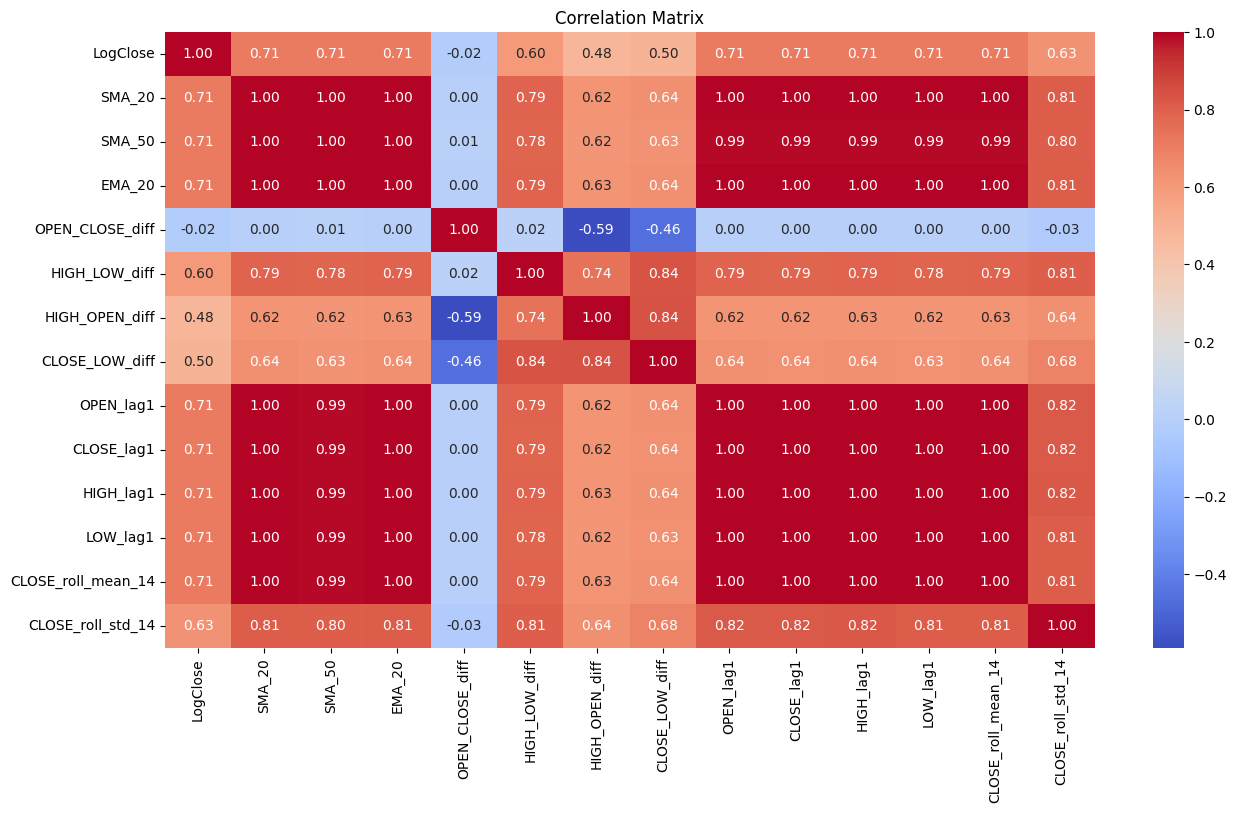

In [38]:
# Compute correlation matrix
correlation_matrix = cleaned_data[feature_cols].corr()

# Visualize correlation
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**Observations:**

1. **Strong Positive Correlations:**
   - The three moving averages (**SMA_20**, **SMA_50**, **EMA_20**) show very high inter-correlation (above 0.90) and also maintain moderately strong relationships with **LogClose** (≥ 0.69). This suggests that these trend indicators and the transformed close price track each other closely over time.  
   - The lagged close features (**CLOSE_lag1**, **CLOSE_roll_mean_14**) exhibit noticeable positive correlations with **LogClose** (around 0.79), indicating that the previous day’s closing price and the recent rolling mean can be strong predictors for the current closing behavior.

2. **Notable Negative or Weak Correlations:**
   - **OPEN_CLOSE_diff** has moderate negative correlations with **OPEN_lag1** (-0.59) and **CLOSE_lag1** (-0.46), implying that large differences between opening and closing prices tend to coincide with lower previous-day open or close values.  
   - **HIGH_OPEN_diff** shows a mild negative relationship with **CLOSE_lag1** (-0.46), suggesting that significant intraday upward movement from the open may not align with a higher previous-day close.  
   - Meanwhile, **LogClose** exhibits near-zero correlation with **OPEN_CLOSE_diff** (0.00) and **CLOSE_LOW_diff** (0.00), indicating that the current logged close price and these particular intraday differences have little direct linear association.


# Data Pre-Processing

## Train-Test Split and Scaling the data

In [39]:
train_frac=0.8
val_frac=0.1

total_samples = len(X_raw)
train_size = int(train_frac * total_samples)
val_size   = int(val_frac * total_samples)

# Train/Val/Test Split
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]
dates_train = dates[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]
dates_val   = dates[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]
dates_test  = dates[train_size + val_size:]

print(f"X_train_raw: {X_train_raw.shape}, X_val_raw: {X_val_raw.shape}, X_test_raw: {X_test_raw.shape}, y_train_raw: {y_train_raw.shape}, y_val_raw: {y_val_raw.shape}, y_test_raw: {y_test_raw.shape}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on TRAIN only for features (reshape to 2D for scaling)
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[2])
scaler_X.fit(X_train_2d)

X_train_final = scaler_X.transform(X_train_2d).reshape(X_train_raw.shape)
X_val_final  = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[2])).reshape(X_val_raw.shape)
X_test_final  = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[2])).reshape(X_test_raw.shape)

# Scale target values if needed (not returned)
y_train_2d = y_train_raw.reshape(-1, 1)
scaler_y.fit(y_train_2d)
y_train_final = scaler_y.transform(y_train_2d).flatten()
y_val_final  = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test_final  = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

print(f"X_train_scaled: {X_train_final.shape}, X_val_scaled: {X_val_final.shape}, X_test_scaled: {X_test_final.shape}, y_train_scaled: {y_train_final.shape}, y_val_scaled: {y_val_final.shape}, y_test_scaled: {y_test_final.shape}")


X_train_raw: (4023, 30, 14), X_val_raw: (502, 30, 14), X_test_raw: (504, 30, 14), y_train_raw: (4023,), y_val_raw: (502,), y_test_raw: (504,)
X_train_scaled: (4023, 30, 14), X_val_scaled: (502, 30, 14), X_test_scaled: (504, 30, 14), y_train_scaled: (4023,), y_val_scaled: (502,), y_test_scaled: (504,)


# Model Training

In [42]:
l2_reg = tf.keras.regularizers.l2(1e-4)
dropout_rate = 0.3

# Determine window_size and number of features from X_train
window_size = X_train_final.shape[1]
num_features = X_train_final.shape[2]

model = Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.LSTM(
        64,
        return_sequences=True,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.Dense(1)  # outputs scaled LogClose
])

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.2836 - mean_absolute_error: 0.3270 - val_loss: 0.0387 - val_mean_absolute_error: 0.0261 - learning_rate: 5.0000e-04
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0563 - mean_absolute_error: 0.1003 - val_loss: 0.0376 - val_mean_absolute_error: 0.0399 - learning_rate: 5.0000e-04
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0500 - mean_absolute_error: 0.0895 - val_loss: 0.0349 - val_mean_absolute_error: 0.0318 - learning_rate: 5.0000e-04
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0466 - mean_absolute_error: 0.0853 - val_loss: 0.0329 - val_mean_absolute_error: 0.0285 - learning_rate: 5.0000e-04
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0430 - mean_absolute_error: 0.0793 - val_loss: 0.0379 - val_mean_absolute_error: 0.0851 - learning_rate: 5.0000e-04
Epoch 6/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0418 - mean_absolute_error: 0.0797 

# Model Evaluation

In [43]:
train_preds_scaled = model.predict(X_train_final).flatten()
val_preds_scaled = model.predict(X_val_final).flatten()
test_preds_scaled = model.predict(X_test_final).flatten()

train_preds_log = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
val_preds_log = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
test_preds_log = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()

# Convert back from log scale
train_preds = np.expm1(train_preds_log)
val_preds = np.expm1(val_preds_log)
test_preds = np.expm1(test_preds_log)

y_train_log = scaler_y.inverse_transform(y_train_final.reshape(-1, 1)).flatten()
y_val_log = scaler_y.inverse_transform(y_val_final.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()

y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_val_log)
y_test_orig = np.expm1(y_test_log)

# ------------------------------------------------------
#  Evaluation
# ------------------------------------------------------
train_mse = mean_squared_error(y_train_orig, train_preds)
val_mse = mean_squared_error(y_val_orig, val_preds)
test_mse = mean_squared_error(y_test_orig, test_preds)

train_mae = mean_absolute_error(y_train_orig, train_preds)
val_mae = mean_absolute_error(y_val_orig, val_preds)
test_mae = mean_absolute_error(y_test_orig, test_preds)

train_r2 = r2_score(y_train_orig, train_preds)
val_r2 = r2_score(y_val_orig, val_preds)
test_r2 = r2_score(y_test_orig, test_preds)

logging.info("Training Metrics:")
logging.info(f" - MSE: {train_mse:.4f}")
logging.info(f" - MAE: {train_mae:.4f}")
logging.info(f" - R²:  {train_r2:.4f}")

logging.info("Validation Metrics:")
logging.info(f" - MSE: {val_mse:.4f}")
logging.info(f" - MAE: {val_mae:.4f}")
logging.info(f" - R²:  {val_r2:.4f}")

logging.info("Test Metrics:")
logging.info(f" - MSE: {test_mse:.4f}")
logging.info(f" - MAE: {test_mae:.4f}")
logging.info(f" - R²:  {test_r2:.4f}")

metrics = {
    "train": {
        "MSE": train_mse,
        "MAE": train_mae,
        "R-squared": train_r2
    },
    "validation": {
        "MSE": val_mse,
        "MAE": val_mae,
        "R-squared": val_r2
    },
    "test": {
        "MSE": test_mse,
        "MAE": test_mae,
        "R-squared": test_r2
    }
}
print(metrics)

126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
{'train': {'MSE': 548828.2444832643, 'MAE': 291.5293447232656, 'R-squared': 0.9975657673923696}, 'validation': {'MSE': 884101.9913546041, 'MAE': 752.1769843296722, 'R-squared': 0.9564885430760043}, 'test': {'MSE': 61731961.31861563, 'MAE': 5079.25455063201, 'R-squared': 0.836150016058292}}


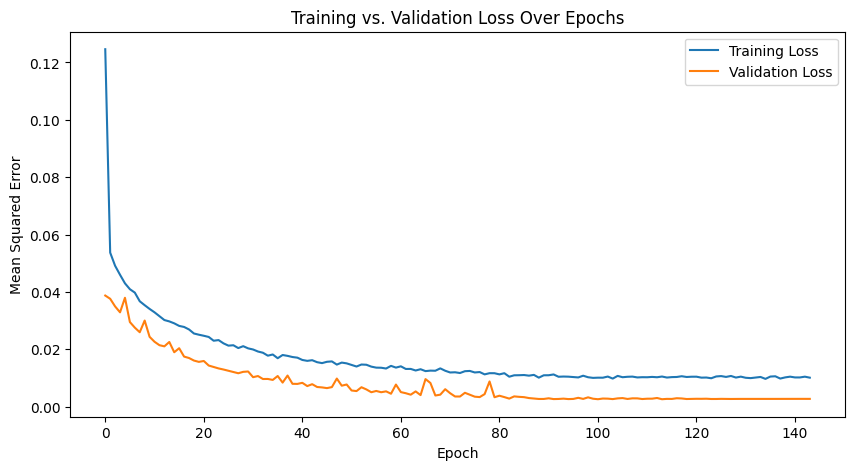

In [44]:
# Assuming 'history' is the History object returned from model.fit()
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

**Observations:**

1. **Convergence Trend:** Both the training loss and validation loss decrease steadily over time, indicating that the model is learning effectively. By around epoch 100, both losses plateau, suggesting the model has reached optimal performance.

2. **No Overfitting:** The validation loss remains consistently lower than the training loss throughout the epochs. This suggests the model is generalizing well to unseen data without signs of overfitting.


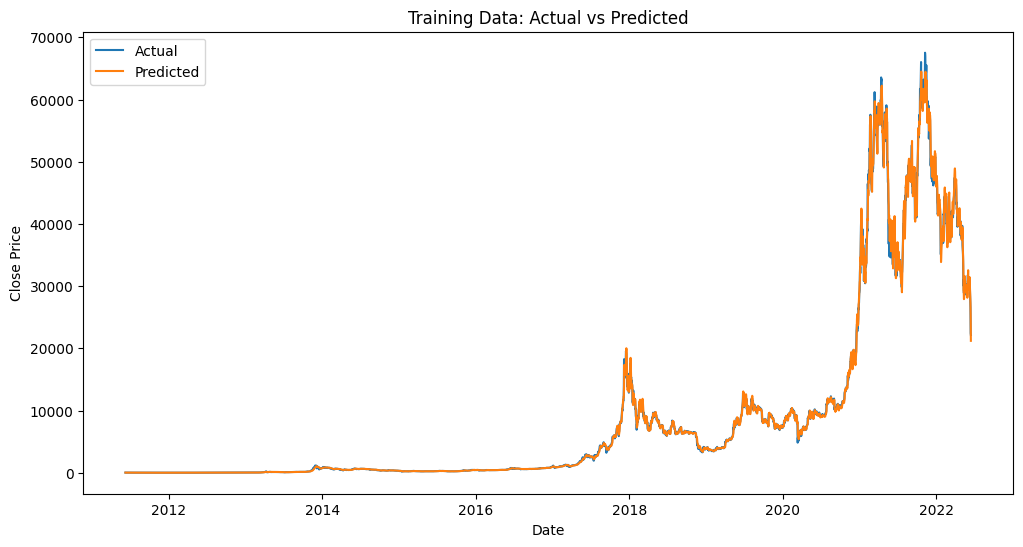

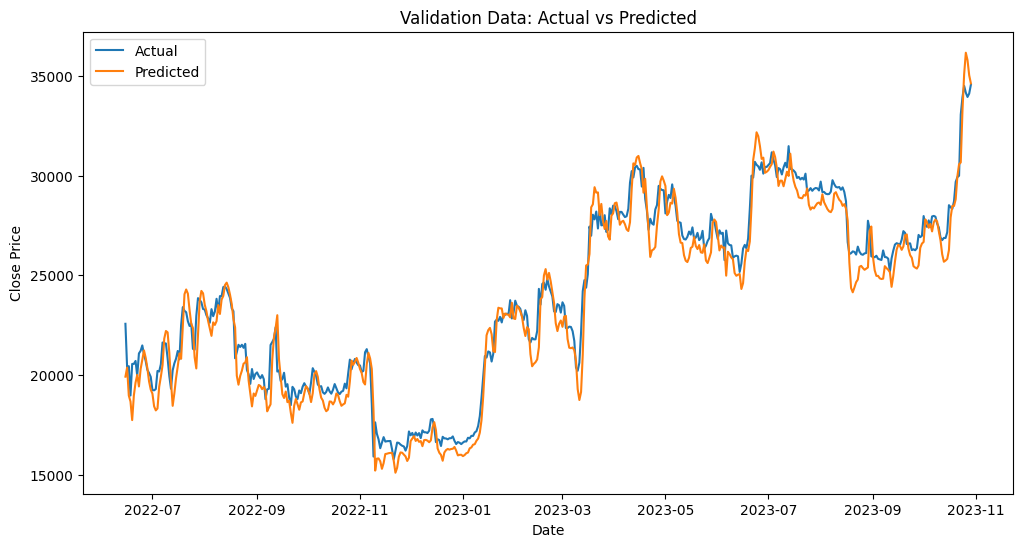

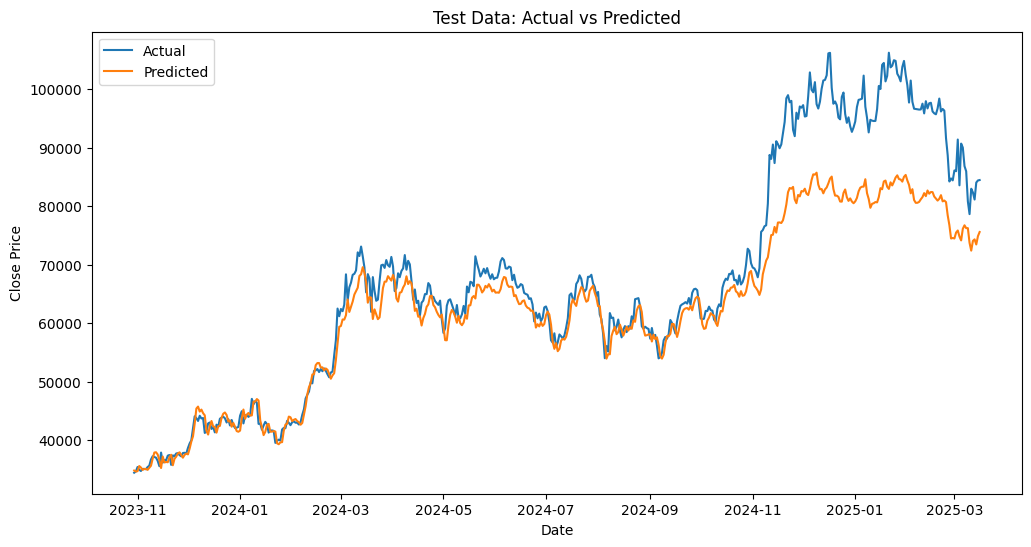

In [45]:
import matplotlib.pyplot as plt

# Plot for Training Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train_orig, label="Actual")
plt.plot(dates_train, train_preds, label="Predicted")
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot for Validation Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_val, y_val_orig, label="Actual")
plt.plot(dates_val, val_preds, label="Predicted")
plt.title("Validation Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot for Test Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_orig, label="Actual")
plt.plot(dates_test, test_preds, label="Predicted")
plt.title("Test Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


**Observations:**

1. **Training Data:** The predicted curve closely follows the actual price trend, indicating the model has effectively learned from historical data.

2. **Validation Data:** The model tracks short-term fluctuations well, suggesting it generalizes effectively to unseen data.

3. **Test Data:** Despite some deviations at higher price levels, the predictions still capture the overall upward and downward movements, demonstrating a reasonable forecasting capability.